# Score de pagamentos Itau Cartões A03

Esse notebook tem por objetivo criar um modelo de classificação de probabilidade de pagamentos para o segmento A03 da carteira Itau Cartões da Zanc.
Faremos uso de uma base de cerca de 100 mil cpfs que tiveram permanencia de 45 completos dentro da empresa.
Nosso target é conseguir distinguir quem tem mais chances de recuperação de crédito de quem não tem.

Hoje já obtivemos algum resultado utilizando Logistic Regression através da ferramenta Orange.
A tarefa inicial será de transportar para esse notebookk com código python o que foi feito no Orange.
Na seqüência será proposto uma outra abordagem utilizando Gradient Boosting

## Preparação dos dados

#### Importando módulos necessários

In [1]:
import numpy as np # Sem ele não somos ninguém
from matplotlib import pyplot # Sem ele não há beleza
import time # Para medir o tempo de execução dos modelos
import pandas as pd # Para carregar os dados em um dataframe
from sklearn.utils import resample # Para balancear os dados
from sklearn.impute import SimpleImputer # Para preencher os campos que estivem com valores nulos
from sklearn.preprocessing import MinMaxScaler # Para normalização dos campos numéricos
from sklearn.linear_model import LogisticRegression # Para instanciar o modelo de Regressão Logística
from sklearn.ensemble import GradientBoostingClassifier # Para instanciar o modelo de Gradient Boosting
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV # Para avaliação dos modelos
import pickle # Para salvar o modelo para uso futuro
import joblib # Para salvar o modelo para uso futuro

#### Importando os dados para um df pandas

Vamos importar o dataframe utilizando a funcao read csv padrão do pandas, analisando as colunas, tipos e valores nulos.

In [2]:
df = pd.read_csv("./data/prever_novo.csv", encoding="latin1", delimiter=";", decimal = ",")
df.head()

,loja,renda,cpf_cnpj,scorecontratante,dataentrada,validadecampanha,atrasocongelado,valorcartacampanha,vlclusters,status_boletagem,data_status_boletagem,desconto,bandeira,publico,matriz,Pagamentos,Acionamentos,Valor_Pago
0,CARTÃO PRIV LBL FIC ASSAI,0,74713,425,21/02/2019 00:00,17/04/2019,253,1582.10,1894.25,BOLETAR_A_PARTIR_,17/03/2019,50.72,FC,0,3,0,26,NaN
1,CARTÃO EXTRA 2.0,0,333751,428,25/04/2019 00:00,19/06/2019,192,392.90,439.42,BOLETAR_A_PARTIR_,19/05/2019,33.60,FC,0,4,0,0,NaN
2,MAGAZINE LUIZA/LUIZACRED FLEX,0,676527,343,02/03/2019 00:00,26/04/2019,197,1069.87,1353.72,BOLETAR_A_PARTIR_,26/03/2019,42.52,LC,0,3,0,5,NaN
3,CARTÃO EXTRA 2.0,0,919799,353,13/12/2018 00:00,06/02/2019,369,1002.21,1717.83,BOLETAR_A_PARTIR_,06/01/2019,71.04,FC,0,3,0,7,NaN
4,CARTÃO EXTRA 2.0,0,1140140,371,18/04/2019 00:00,12/06/2019,307,874.41,988.66,BOLETAR_A_PARTIR_,12/05/2019,53.04,FC,ElegÃ­vel ExceÃ§Ã£o,3,0,1,NaN


In [5]:
df.shape

(111848, 18)

In [3]:
df.isna().sum()

loja                          0
renda                         0
cpf_cnpj                      0
scorecontratante              0
dataentrada                   0
validadecampanha              0
atrasocongelado               0
valorcartacampanha            0
vlclusters                    0
status_boletagem              0
data_status_boletagem         0
desconto                      0
bandeira                      0
publico                       0
matriz                        0
Pagamentos                    0
Acionamentos                  0
Valor_Pago               109295
dtype: int64

#### Tratando renda nula

In [4]:
df.astype(bool).sum(axis=0)

loja                     111848
renda                         0
cpf_cnpj                 111848
scorecontratante         111420
dataentrada              111848
validadecampanha         111848
atrasocongelado          111848
valorcartacampanha       111848
vlclusters               111813
status_boletagem         111848
data_status_boletagem    111848
desconto                 111810
bandeira                 111848
publico                  111848
matriz                   111812
Pagamentos                 2553
Acionamentos              59379
Valor_Pago               111848
dtype: int64

In [108]:
#imp = SimpleImputer(strategy='mean')
#imp.fit(df['renda  '].values.reshape(-1,1))
#df['renda  '] = imp.transform(df['renda  '].values.reshape(-1,1))

#### Normalizando campos numéricos

In [5]:
escalador_vlrcartacampanha = MinMaxScaler()
escalador_vlrccluster = MinMaxScaler()
escalador_vlrdesconto = MinMaxScaler()
df['valorcartacampanha_s'] = escalador_vlrcartacampanha.fit_transform(df[['valorcartacampanha']].values)
df['vlclusters_s'] = escalador_vlrccluster.fit_transform(df[['vlclusters']].values)
df['desconto_s'] = escalador_vlrdesconto.fit_transform(df[['desconto']].values)
#escalador_renda = MinMaxScaler()
#df['renda  '] = escalador_renda.fit_transform(df[['renda  ']].values)

In [143]:
df['loja'].value_counts()

MAGAZINE LUIZA/LUIZACRED FLEX                32317
HIPERCARD                                    14884
CARTÃO EXTRA 2.0                            12054
CARTÃO PONTO FRIO 2.0                        6828
CARTÃO MARISA 2.0                            6362
CARTÃO WALMART 2.0                           6305
CREDICARD CLASSICOS                           4567
CARTÃO PRIV LBL FIC ASSAI                    3906
CARTAO PL FIC CB S/P                          3402
ITAUCARD 2.0 CANAIS DIRETOS                   3080
OPERACOES CREDITO CREDICARD                   2721
CARTAO PL FIC EXTRA S/P                       2154
TAM ITAUCARD 2.0                              1450
CARTAO PL EMBANDEIRADO MARISA                 1435
CARTAO PL FIC EXTRA BAND                      1161
Cartao Cobranded Netshoes 2.0                 1108
PL PURO ITAUCARD LOJISTA                       930
TITULARES CARTOES DE CREDITO                   752
FAI PL EMBANDEIRADO AMERICANAS                 536
CARTÃO IPIRANGA 2.0           

#### Tratando Loja

In [6]:
def trata_loja(x):
    lojas = ['CARTÃO EXTRA 2.0',
             'CARTÃO MARISA 2.0',
             'CARTAO PL EMBANDEIRADO MARISA',
             'CARTAO PL FIC CB S/P',
             'CARTAO PL FIC EXTRA BAND',
             'CARTAO PL FIC EXTRA S/P',
             'CARTÃO PONTO FRIO 2.0',
             'CARTÃO PRIV LBL FIC ASSAI',
             'CARTÃO WALMART 2.0',
             'CREDICARD CLASSICOS',
             'HIPERCARD',
             'ITAUCARD 2.0 CANAIS DIRETOS',
             'MAGAZINE LUIZA/LUIZACRED FLEX',
             'OPERACOES CREDITO CREDICARD',             
             'TAM ITAUCARD 2.0']
    if x in lojas:
        return x
    else:
        return 'OUTROS'
df['loja'] = df['loja'].apply(trata_loja)
df['loja'].value_counts()

OUTROS                           44677
MAGAZINE LUIZA/LUIZACRED FLEX    32317
HIPERCARD                        14884
CREDICARD CLASSICOS               4567
CARTAO PL FIC CB S/P              3402
ITAUCARD 2.0 CANAIS DIRETOS       3080
OPERACOES CREDITO CREDICARD       2721
CARTAO PL FIC EXTRA S/P           2154
TAM ITAUCARD 2.0                  1450
CARTAO PL EMBANDEIRADO MARISA     1435
CARTAO PL FIC EXTRA BAND          1161
Name: loja, dtype: int64

#### Tratando público

In [7]:
df['publico'].value_counts()

0                         70152
elegivel_excecao          23983
ElegÃ­vel ExceÃ§Ã£o       11902
Elegivel Excecao           2639
alto_atrito                1939
Alto Atrito                1090
Eleg?Â¡vel Exce?Âº?Ãºo      142
883000140672                  1
Name: publico, dtype: int64

In [8]:
def converte_publico(x):
    if x=="Eleg?¡vel Exce?º?úo" or x=="Elegível Exceção" or x=="Elegivel Excecao" or x=="ElegÃ­vel ExceÃ§Ã£o" or x=="Eleg?Â¡vel Exce?Âº?Ãºo" or x=="Eleg?el Exce?o" or x=="Eleg??vel Exce????":
        return "elegivel_excecao"
    elif x=="Alto Atrito":
        return "alto_atrito"
    elif x=="0" or x=="883000140672" or x=="8,83E+11":
        return "nao_definido"
    else:
        return x

df['publico'] = df['publico'].apply(converte_publico)
df['publico'].value_counts()

nao_definido        70153
elegivel_excecao    38666
alto_atrito          3029
Name: publico, dtype: int64

#### Transformando colunas categóricas em binárias

In [9]:
colunas_treino = ['loja',
                  'renda',
                  'scorecontratante',
                  'atrasocongelado',
                  'valorcartacampanha_s',
                  'vlclusters_s',
                  'status_boletagem',
                  'desconto_s',
                  'bandeira',
                  'publico',
                  'matriz'
                 ]

In [10]:
dummies = pd.get_dummies(df[colunas_treino])
dropado = df.drop(colunas_treino,axis=1)
df = pd.concat([dummies,dropado], axis=1)

In [11]:
df.head()

,renda,scorecontratante,atrasocongelado,valorcartacampanha_s,vlclusters_s,desconto_s,matriz,loja_CARTAO PL EMBANDEIRADO MARISA,loja_CARTAO PL FIC CB S/P,loja_CARTAO PL FIC EXTRA BAND,...,cpf_cnpj,dataentrada,validadecampanha,valorcartacampanha,vlclusters,data_status_boletagem,desconto,Pagamentos,Acionamentos,Valor_Pago
0,0,425,253,0.023061,0.019467,0.512323,3,0,0,0,...,74713,21/02/2019 00:00,17/04/2019,1582.10,1894.25,17/03/2019,50.72,0,26,NaN
1,0,428,192,0.005607,0.004516,0.339394,4,0,0,0,...,333751,25/04/2019 00:00,19/06/2019,392.90,439.42,19/05/2019,33.60,0,0,NaN
2,0,343,197,0.015543,0.013912,0.429495,3,0,0,0,...,676527,02/03/2019 00:00,26/04/2019,1069.87,1353.72,26/03/2019,42.52,0,5,NaN
3,0,353,369,0.014550,0.017654,0.717576,3,0,0,0,...,919799,13/12/2018 00:00,06/02/2019,1002.21,1717.83,06/01/2019,71.04,0,7,NaN
4,0,371,307,0.012674,0.010160,0.535758,3,0,0,0,...,1140140,18/04/2019 00:00,12/06/2019,874.41,988.66,12/05/2019,53.04,0,1,NaN


#### Separando treino e teste

In [12]:
df['Pagamentos'].value_counts()

0    109295
1      2553
Name: Pagamentos, dtype: int64

In [14]:
df_maioria = df[df.Pagamentos==0]
df_minoria = df[df.Pagamentos==1]
df_maioria_randomizado = resample(df_maioria, 
                                 replace=True,     
                                 n_samples=2533,    
                                 random_state=123)
df_balanceado = pd.concat([df_maioria_randomizado, df_minoria])
df_balanceado.Pagamentos.value_counts()

1    2553
0    2533
Name: Pagamentos, dtype: int64

In [81]:
dummies.columns

Index(['renda', 'scorecontratante', 'atrasocongelado', 'valorcartacampanha_s',
       'vlclusters_s', 'desconto_s', 'matriz',
       'loja_CARTAO PL EMBANDEIRADO MARISA', 'loja_CARTAO PL FIC CB S/P',
       'loja_CARTAO PL FIC EXTRA BAND', 'loja_CARTAO PL FIC EXTRA S/P',
       'loja_CREDICARD CLASSICOS', 'loja_HIPERCARD',
       'loja_ITAUCARD 2.0 CANAIS DIRETOS',
       'loja_MAGAZINE LUIZA/LUIZACRED FLEX',
       'loja_OPERACOES CREDITO CREDICARD', 'loja_OUTROS',
       'loja_TAM ITAUCARD 2.0', 'status_boletagem_0',
       'status_boletagem_BOLETAR_A_PARTIR_',
       'status_boletagem_BOLETAR_A_VONTADE', 'bandeira_CC', 'bandeira_CR',
       'bandeira_FA', 'bandeira_FC', 'bandeira_FT', 'bandeira_HC',
       'bandeira_LC', 'bandeira_MA', 'publico_alto_atrito',
       'publico_elegivel_excecao', 'publico_nao_definido'],
      dtype='object')

In [15]:
y_train = df_balanceado.Pagamentos.values
X_train = df_balanceado[dummies.columns].values
y_test = df.Pagamentos.values
X_test = df[dummies.columns].values

#### Treinando e predizendo com LogReg


In [152]:
param_grid_lr = {
    'dual': [True,False],
    'max_iter': [100,110,120,130,140],
    'C': [1.0,1.5,2.0,2.5,3.5]
}
lr = LogisticRegression()
grid_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
start_time = time.time()
grid_result = grid_lr.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.649766 using {'C': 3.5, 'dual': False, 'max_iter': 100}
Execution time: 4.174563884735107 ms


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [133]:
pred = grid_result.predict_proba(X_test)
df_predicted = df_dummies
df_predicted['pagamentos real'] = y_test
df_predicted['prob prevista'] = pred[:,1]
df_predicted.to_csv('logreg_predicted.csv', decimal=',', sep=";")

NameError: name 'df_dummies' is not defined

#### Treinando e predizendo com XgBoosting

In [16]:
param_grid_xg = {
        'n_estimators':[100,200,400,600],
        'min_samples_leaf':[5,10,20],
        'subsample': [0.6, 0.8, 1.0]
        }
xg = GradientBoostingClassifier(learning_rate=0.02)
grid_xg = GridSearchCV(estimator=xg, param_grid=param_grid_xg, cv=5, scoring='roc_auc', n_jobs=-1)
grid_result_xg = grid_xg.fit(X_train, y_train)
start_time = time.time()
print("Best: %f using %s" % (grid_result_xg.best_score_, grid_result_xg.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.679602 using {'min_samples_leaf': 5, 'n_estimators': 200, 'subsample': 0.6}
Execution time: 0.00043773651123046875 ms


In [135]:
pred = grid_result_xg.predict_proba(X_test)
df_predicted = df
df_predicted['prob prevista'] = pred[:,1]
df_predicted.to_csv(r'data\xgboost_train_result_predict.csv', decimal=',', sep=";")

PermissionError: [Errno 13] Permission denied: 'data\\xgboost_train_result_predict.csv'

#### Feature Importance

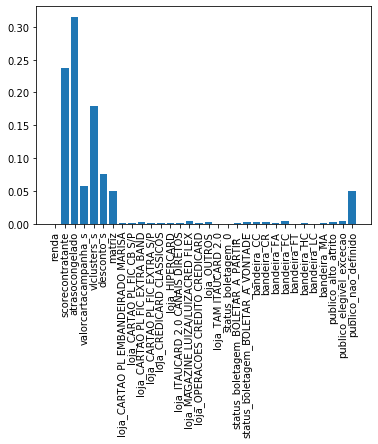

In [17]:
pyplot.bar(range(len(grid_result_xg.best_estimator_.feature_importances_)), grid_result_xg.best_estimator_.feature_importances_)
pyplot.xticks(range(len(grid_result_xg.best_estimator_.feature_importances_)),dummies.columns, rotation='vertical')
pyplot.show()

#### Salvando os Scalers e o Xgboosting

In [19]:
joblib.dump(escalador_vlrcartacampanha, r"models/scaler_vlrcartacampanha_a03.pkl")
joblib.dump(escalador_vlrccluster, r"models/scaler_vlrcluster_a03.pkl")
joblib.dump(escalador_vlrdesconto, r"models/scaler_vlrdesconto_a03.pkl")
joblib.dump(grid_result_xg, r"models/xgboosting_a03.pkl")

['models/xgboosting_a03.pkl']

 #### To-do

1. Adicionar a variavel do bom bureau
2. Transformar matriz em dummy
3. Abrir mais o produto
4. Trabalhar na seleção de features para ver se melhora a roc
5. Testar outros modelos para ver assertividade
6. Criar tratamento para nulos, pois eles foram retirados nessa amostra e será necessário para treinar no futuro
7. Analisar outras opções além do minmaxscaller